In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./input/titanic/train.csv')
test = pd.read_csv('./input/titanic/test.csv')
submission = pd.read_csv('./input/titanic/gender_submission.csv')
train.shape, test.shape, submission.shape

((891, 12), (418, 11), (418, 2))

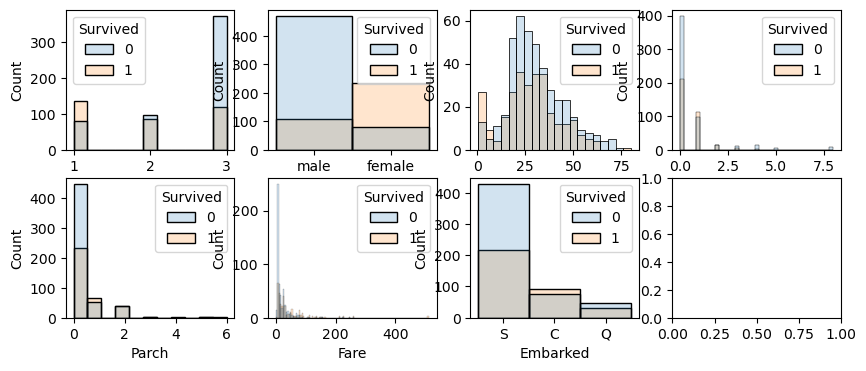

In [3]:
columns = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
fig, ax = plt.subplots(2,4,figsize=(10,4))
ax = ax.flatten()
for i, col in enumerate(columns):
    sns.histplot(data=train, x=col, hue='Survived', ax=ax[i], alpha=0.2)
plt.show()

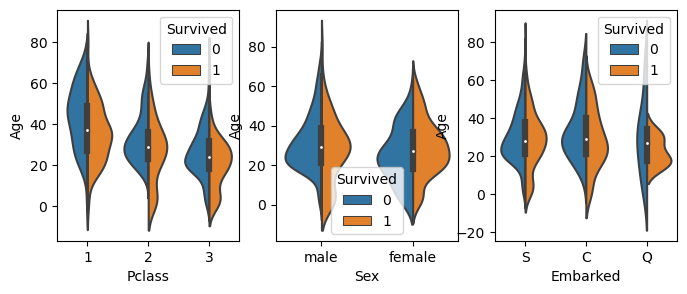

In [4]:
fig, ax = plt.subplots(1,3,figsize=(8,3))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, split=True, ax=ax[0])
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, split=True, ax=ax[1])
sns.violinplot(x='Embarked', y='Age', hue='Survived', data=train, split=True, ax=ax[2])
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_18208\2785141731.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  co_matrix = train.corr()


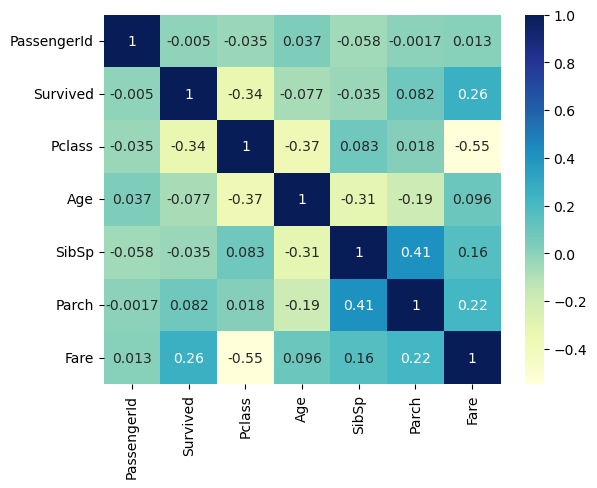

In [5]:
co_matrix = train.corr()
sns.heatmap(co_matrix, cmap="YlGnBu", annot=True)
plt.show()

In [6]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived'].copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [7]:
X = pd.concat(train.drop('Survived',axis=1), test)
X[X['Age'].isnull()]['Name'].head()

5                  Moran, Mr. James
17     Williams, Mr. Charles Eugene
19          Masselmani, Mrs. Fatima
26          Emir, Mr. Farred Chehab
28    O'Dwyer, Miss. Ellen "Nellie"
Name: Name, dtype: object

In [8]:
X['AgeName'] = X['Name'].str.extract('([A-Za-z]+)\.')
pd.crosstab(X['AgeName'], X['Sex']).T.style.background_gradient(cmap='Blues')

AgeName,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [9]:
X['AgeName'].replace(['Capt','Col','Countess','Don','Dr','Jonkheer','Lady','Dona',
                               'Major','Mlle','Mme','Ms','Rev','Sir'],
                         ['Mr','Other','Mrs','Mr','Mr','Other','Mrs','Miss',
                              'Mr','Miss','Miss','Miss','Other','Mr'], inplace=True)
X.groupby('AgeName')['Age'].mean().to_frame().astype(int)

,Age
AgeName,
Master,5
Miss,21
Mr,32
Mrs,37
Other,44


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [10]:
# Fill Age
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, check='mean'):
        self.check = check
        self.last_li = ['Capt','Col','Countess','Don','Dr','Jonkheer','Lady','Dona',
                        'Major','Mlle','Mme','Ms','Rev','Sir']
        self.replace_li = ['Mr','Other','Mrs','Mr','Mr','Other','Mrs','Miss',
                           'Mr','Miss','Miss','Miss','Other','Mr']     
    def fit(self, X, y=None):
        func = self.check
        copyX = X[['Name','Age']].copy()
        copyX['AgeName'] = copyX['Name'].str.extract('([A-Za-z]+)\.')
        copyX['AgeName'].replace(self.last_li, self.replace_li, inplace=True)
        fill_df = copyX.groupby('AgeName')['Age'].agg(func).to_frame().astype(int)
        self.AgeName_li = list(fill_df.index)
        self.meanAge_li = list(fill_df['Age'])
        return self
    def transform(self, X):
        for AgeName, meanAge in zip(self.AgeName_li, self.meanAge_li):
            X.loc[(X['Age'].isnull())&(X['AgeName']==AgeName), 'Age'] = meanAge
        return X

In [13]:
X['Cabin_C'] = train['Cabin'].str[:1]
pd.crosstab(X['Pclass'], X['Cabin_C']).style.background_gradient(cmap='Blues')

Cabin_C,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,17,49,67,32,28,2,1,1
2,1,6,6,8,7,11,0,0
3,3,8,18,7,8,8,7,1


In [14]:
X.groupby('Pclass')['Cabin_C'].agg(**{'most_common_value':lambda x:x.mode()})

,most_common_value
Pclass,
1,C
2,F
3,C


In [16]:
# Fill Cabin
class CabinImputer(BaseEstimator, TransformerMixin):
    def __init__(self, check='mode'):
        self.check = check
    def fit(self, X, y=None):
        copyX = X[['Cabin','Pclass']].copy()
        copyX['Cabin_C'] = copyX['Cabin'].str[:1]
        fill_df = copyX.groupby('Pclass')['Cabin_C'].agg(**{'most_common_value':lambda x:x.mode()})
        self.Pclass_li = list(fill_df.index)
        self.mode_v_li = list(fill_df['most_common_value'])
        return self
    def transform(self, X):
        X.['Cabin'] = X['Cabin'].str[:1]
        for Pclass, mode_val in zip(self.Pclass_li, self.mode_v_li):
            X.loc[(X['Cabin'].isnull())&(X['Pclass']==Pclass), 'Cabin'] = mode_val
        return X

In [11]:
# Fill Fare
class FareImputer(BaseEstimator, TransformerMixin):
    def __init__(self, check='mean'):
        self.check = check
    def fit(self, X, y=None):
        func = self.check
        copyX = X[['Fare','Pclass']].copy()
        fill_df = copyX.groupby('Pclass')['Fare'].agg(func)
        self.Pclass_li = list(fill_df.index)
        self.mean_F_li = list(fill_df['Fare'])
        return self
    def transform(self, X):
        for Pclass, mean_Fare in zip(self.Pclass_li, self.mean_F_li):
            X.loc[(X['Fare'].isnull())&(X['Pclass']==Pclass), 'Fare'] = mean_Fare
        return X

In [17]:
class ColsAdderChooser(BaseEstimator, TransformerMixin):
    def __init__(self, Fare_cat=False, use_Family=False, Family_cat=False, Age_cat=False):
        self.Fare_cat = Fare_cat
        self.use_Family = use_Family
        self.Family_cat = Family_cat
        self.Age_cat = Age_cat
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.Fare_cat:
            bins, label = [0,7.91,14.45,31,np.inf], ['VeryCheap','Cheap','medium','high']
            X['FareCut'] = pd.cut(X['Fare'], bins, right=False, labels=label)
            X.drop('Fare', axis=1, inplace=True)
        
        if self.use_Family:
            X['Family '] = X['SibSp'] + X['Parch'] + 1
            X.drop(['SibSp','Parch'], axis=1, inplace=True)
            if self.Family_cat:
                bins, label = [0,1,2,4,np.inf], ['Single','SmallF','MedF','LargeF']
                X['FamilyCat']pd.cut(X['Family'], bins, right=False, labels=label)
                X.drop('Family', axis=1, inplace=True)

        if self.Age_cat:
            bins, label = [0,15,29,35,55,np.inf], ['Children','Youth','YoungAdult','MiddleAged','Senior']
            X['AgeCat'] = pd.cut(X['Age'], bins, right=False, labels=label)
            X.drop('age', axis=1, inplace=True)
        return X

In [ ]:
# 여기부터 다시

In [ ]:
EmbarkedImpute = ColumnTransformer([
    ('impute', Simpleimputer(strategy='constant', fill_value='S').set_output(transform='pandas'),
     ['Embarked'])
], remainder='passthrough').set_output(transform='pandas')
OneHot = ColumnTransformer([
    ('onehot': OneHotEncoder(drop='if_binary'), ['remainder__sex', 'impute__embarked'])
], remainder='passthrough')

pre_pipeline = Pipeline([
    ('AgeImpute': AgeImputer()), ('CabinImpute': CabinImputer()), ('FareImpute': FareImputer()),
    ('columns_choose': ColsAdderChooser(Fare_cat=True, use_Family=True, Family_cat=True, Age_cat=True)),
    ('EmbarkedImpute': EmbarkedImpute),
    ('OneHot': OneHot)
])

In [20]:
drop_cols = ['PassengerId','Name','SibSp','Parch','Ticket','Cabin','AgeName']
X.drop(columns=drop_cols, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    1309 non-null   int64   
 1   Sex       1309 non-null   object  
 2   Age       1309 non-null   float64 
 3   Fare      1308 non-null   float64 
 4   Embarked  1307 non-null   object  
 5   FareCut   1308 non-null   category
 6   Cabin_C   1309 non-null   object  
 7   Family    1309 non-null   int64   
 8   FamilySz  1309 non-null   category
 9   AgeCat    1308 non-null   category
dtypes: category(3), float64(2), int64(2), object(3)
memory usage: 86.4+ KB


In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [24]:
num_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='median'))])
cat_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe_encoder', OneHotEncoder(sparse_output=False))])

TypeError: __init__() got an unexpected keyword argument 'sparse_output'

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'Fare', 'FareCut', 'Family']
cat_attribs = ['Pclass', 'Sex', 'Embarked', 'Cabin_C', 'FamilySz', 'AgeCat']

full_pipeline = ColumnTransformer([
                    ('num', SimpleImputer(strategy='median'), num_attribs), # 수치형
                    ('cat', cat_pipeline, cat_attribs)])  # 범주형
X_train = full_pipeline.fit_transform(X)

In [ ]:
X_test = X_train.iloc[-418:]
X_train = X_train.iloc[:-418]
y_train = train['Survived']
X_train.shape, y_train.shape, X_test.shape

In [ ]:
from sklearn.model_selection import cross_val_score # 교차검증
scoring = 'accuracy'
cv = 5
score = {}

In [ ]:
reg_scoring = 'neg_mean_squared_error'
# 선형회귀 (교차검증)
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
score['LinReg_rmse'] = cross_val_score(lin_reg, X_train, y_train, scoring=reg_scoring, cv=cv)

# 확률경사하강, 표준정규화
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
sgd_reg = SGDRegressor()
score['SGDReg_rmse'] = cross_val_score(sgd_reg, X_train_scaled, y_train, scoring=reg_scoring, cv=cv)

# 다항회귀
from sklearn.preprocessing import PolynomialFeatures
poly_feature = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_feature.fit_transform(X_train)
# 다항회귀(정규방정식)
poly_lin_reg = LinearRegression()
score['Poly_LinReg_rmse'] = cross_val_score(poly_lin_reg, X_train_poly, y_train, 
                         scoring=reg_scoring, cv=cv)

# 다항회귀(확률경사)
poly_std_scaler = StandardScaler()
X_train_scaled_poly = poly_std_scaler.fit_transform(X_train_poly)
poly_sgd_reg = SGDRegressor(penalty=None, random_state=42)
score['Poly_SGDReg_rmse'] = cross_val_score(poly_sgd_reg, X_train_scaled_poly, y_train, 
                         scoring=reg_scoring, cv=cv)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
# LogisticRegression
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
model = LogisticRegression(max_iter=10000)
score['LogisticRegression'] = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=scoring)

# DecisionTreeClassifier
model = DecisionTreeClassifier()
score['DecisionTreeClassifier'] = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

# SVC
model = SVC()
score['SVC'] = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

# RandomForestClassifier
model = RandomForestClassifier(n_estimators=13)
score['RandomForestClassifier'] = cross_val_score(model, X_train, y_train, cv=cv, 
                                                  n_jobs=1, scoring=scoring)

# KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=13)
score['KNeighborsClassifier'] = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

# GaussianNB
model = GaussianNB()
score['GaussianNB'] = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)

In [ ]:
# 교차검증 평균 정확도%
for k,v in score.items():
    if k[-4:]=='rmse':
        print(k,':',np.sqrt(-v.mean()))
    else:
        print(k,':',round(np.mean(v)*100,2))
    
# 제일 높은모델로 테스트

In [ ]:
# start test
test_model = RandomForestClassifier()
test_model.fit(X_train, y_train)

import collections
pred = test_model.predict(test)
pred.shape, collections.Counter(pred), submission.shape, collections.Counter(submission['Survived'])

In [ ]:
from sklearn.metrics import accuracy_score
round(accuracy_score(submission['Survived'], pred)*100,2)

In [ ]:
# submission['Survived'] = pred
# ver = 2
# submission.to_csv('./output/submission_titanic_{}.csv'.format(ver), index = False)

In [ ]:
class myDataTrans:
    def __init__(self):
        self.drop_cols=[]
        
    def fill_Age(self, X): # Age
        fill_df = X.groupby('AgeName')['Age'].mean().to_frame().astype(int)
        AgeName_li = list(fill_df.index)
        meanAge_li = list(fill_df['Age'])
        for i in range(len(AgeName_li)):
            X.loc[(X['Age'].isnull())&(X['AgeName']==AgeName_li[i]), 'Age'] = meanAge_li[i]
        self.drop_cols.extend(['AgeName','Name'])
    
    def mk_col_FareCut(self, X):
        Fmax = int(X['Fare'].max())+1
        Fmin = int(X['Fare'].min())
        Fminmax = (Fmax-Fmin)//10 - (Fmax-Fmin)%10
        bins = list(range(Fmin,Fmax+Fminmax,Fminmax))
        bins_label = [n+Fminmax/2 for n in a[:-1]]
        X['FareCut'] = pd.cut(X['Fare'], bins, right=False, labels=bins_label)
        self.drop_cols.extend(['SibSp','Parch','Fare'])
        
    def fill_Cabin_C(self, X):
        X.loc[(X['Pclass']==1)&((X['FareCut']==72.0)|(X['FareCut']==504.0)),'Cabin_C'] = 'B'
        X.loc[(X['Pclass']==2)&(X['FareCut']==72.0),'Cabin_C'] = 'C'
        fill_df = X.groupby('Pclass')['Cabin_C'].agg(**{'most_common_value':lambda x:x.mode()})
        Pclass_li = list(fill_df.index)
        modeCabin_li = list(fill_df['most_common_value'])
        for i in range(len(Pclass_li)):
            X.loc[X['Pclass']==Pclass_li[i], 'Cabin_C'] = modeCabin_li[i]
        drop_cols.extend(['Cabin'])
        
    def mk_col_FamilySz(self, X): # FamilySz, FareCut
        X['Family'] = X['SibSp'] + X['Parch'] + 1
        bins = [0,1,2,4,12]
        X['FamilySz'] = pd.cut(X['Family'], bins, right=False, labels=['Single','SmallF','MedF','LargeF'])

    def mk_col_AgeCat(self, X):
        bins = [0,18,25,35,60,80]
        group_names = ['Children', 'Youth', 'YoungAdult', 'MiddleAged', 'Senior']
        X['AgeCat'] = pd.cut(X['Age'], bins, right=False, labels=group_names)
        
    def concat_dummies(self, X, dummy_col): # Sex, Embarked, FamilySz
        dummies = pd.get_dummies(X[dummy_col])
        X = pd.concat([X, dummies], axis=1)
        X.drop(columns=dummy_col, inplace=True)